J1:
Swedish: ['Morän', 'Postglacial sand--grus', 'Svallsediment, grus--block', 'Torv', 'Isälvssediment', 'Lera--silt']
Finnish: ['Moreeni', 'Jääkauden jälkeinen hiekka--sora', 'Huuhdottu sedimentti, sora--kivet', 'Turve', 'Sulamisvesisedimentti', 'Savi--lieju']
English: ['Moraine', 'Postglacial sand--gravel', 'Washed sediment, gravel--boulders', 'Peat', 'Glaciofluvial sediment', 'Clay--silt']

J2:
Swedish: ['Fyllning', 'Isälvssediment', 'Torv', 'Postglacial sand', 'Älvsediment, sand', 'Vatten', 'Morän', 'Lera--silt', 'Berg']
Finnish: ['Täyttömaa', 'Sulamisvesisedimentti', 'Turve', 'Jääkauden jälkeinen hiekka', 'Jokisedimentti, hiekka', 'Vesi', 'Moreeni', 'Savi--lieju', 'Kallio']
English: ['Fill', 'Glaciofluvial sediment', 'Peat', 'Postglacial sand', 'Fluvial sediment, sand', 'Water', 'Moraine', 'Clay--silt', 'Bedrock']

J1_J2:
Swedish: [

In [24]:
import tools
import rasterio
import geopandas as gpd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

### CATCHMENTS SHAPEFILE DETERMINES THE BOUNDS SUBSET (FROM KRYCKLAN DATABASE)

In [2]:
file = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/CATCHMENTS/Krycklan_catchments/Krycklan catchments.shp'
df = gpd.read_file(file)
subset = df.total_bounds
subset = subset.round(0)

### SLU FOREST MAP (FROM ONLINE)

In [3]:
fd = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP/2010/'
out_fd = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/'
p = os.path.join(fd, '*.tif')
for file in glob.glob(p):
    out_fn = file.rpartition('/')[-1][:-4]
    out_fp = os.path.join(out_fd, out_fn) + '.asc'
    tools.open_raster_with_subset(file, out_fp, subset, plot=False, save_in='asc')
fd = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN/2010/'
out_fd = '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN_25/2010/'
p = os.path.join(fd, '*.asc')
for file in glob.glob(p):
    out_fn = file.rpartition('/')[-1][:-4]
    out_fp = os.path.join(out_fd, out_fn) + '.asc'
    scale_factor = 24.9925557678120000/25.0
    tools.resample_raster(fp=file, out_fp=out_fp, scale_factor=scale_factor, resampling_method='nearest', plot=False, save_in='asc')

### DEM (FROM KRYCKLAN DATABASE)

In [4]:
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM.tif'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_subset.tif'
tools.open_raster_with_subset(fp=fp, out_fp=out_fp, subset=subset, plot=False, save_in='asc')


(<open DatasetReader name='/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_resample.tif' mode='r'>,
 '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_resample.tif')

In [ ]:
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_subset.tif'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/DEM/Krycklan_2015_DEM_0.5m/Krycklan_2015_DEM_resample.tif'
scale_factor = 0.5/25.0
tools.resample_raster(fp=fp, out_fp=out_fp, scale_factor=scale_factor, resampling_method='bilinear', plot=False, save_in='asc')

### LAI (FROM HENRIK)

In [3]:
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/LAI_Krycklan_ALS_2019.tif'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/LAI_Krycklan_ALS_2019_subset.tif'
tools.open_raster_with_subset(fp=fp, out_fp=out_fp, subset=subset, plot=False, save_in='asc')

In [4]:
fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/LAI_Krycklan_ALS_2019_subset.tif'
scale_factor = 10/25
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/LAI_Krycklan_ALS_2019_subset_25.tif'
tools.resample_raster(fp=fp, out_fp=out_fp, scale_factor=scale_factor, resampling_method='bilinear', plot=False, save_in='asc')

(<open DatasetReader name='/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/LAI_Krycklan_ALS_2019_subset_25.tif' mode='r'>,
 '/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/KRYCKLAN_LAI/LAI_Krycklan_ALS_2019_subset_25.tif')

### SOIL MAP (FROM ANNELI)

In [93]:
file1= r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.shp'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp'
df1 = gpd.read_file(file1)
df2 = gpd.read_file(file2)
codes = {}
for id in df1['JY1'].unique():
    codes[id] = df1.loc[df1['JY1'] == id, 'JY1_TX'].iloc[0]
for id in df2['JG2'].unique():
    codes[id] = df2.loc[df2['JG2'] == id, 'JG2_TX'].iloc[0]

/Users/jpnousu/miniconda3/envs/pysheds/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: /Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  result = ogr_read(


In [98]:
codes

{100: 'Morän',
 84: 'Postglacial sand--grus',
 89: 'Svallsediment, grus--block',
 75: 'Torv',
 50: 'Isälvssediment',
 86: 'Lera--silt',
 200: 'Fyllning',
 31: 'Postglacial sand',
 8809: 'Älvsediment, sand',
 91: 'Vatten',
 888: 'Berg'}

In [97]:
soil_types = {
    100: 'Moraine',
    84: 'Postglacial sand--gravel',
    89: 'Washed sediment, gravel--boulders',
    75: 'Peat',
    50: 'Glaciofluvial sediment',
    86: 'Clay--silt',
    200: 'Fill',
    31: 'Postglacial sand',
    8809: 'Fluvial sediment, sand',
    91: 'Water',
    888: 'Bedrock'
}
soil_types

{100: 'Moraine',
 84: 'Postglacial sand--gravel',
 89: 'Washed sediment, gravel--boulders',
 75: 'Peat',
 50: 'Glaciofluvial sediment',
 86: 'Clay--silt',
 200: 'Fill',
 31: 'Postglacial sand',
 8809: 'Fluvial sediment, sand',
 91: 'Water',
 888: 'Bedrock'}

In [7]:
file1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.shp'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp'
out_fp1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.tif'
out_fp2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.tif'
ref_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SLU_FOREST_MAP_KRYCKLAN_25/2010/BIRCHVOL_XX_P_10.asc'
tools.rasterize_shapefile(shapefile=file1, burn_field='JY1', subset=None, out_fp=out_fp1, ref_raster=ref_fp, plot=False, save_in='geotiff')
tools.rasterize_shapefile(shapefile=file2, burn_field='JG2', subset=None, out_fp=out_fp2, ref_raster=ref_fp, plot=False, save_in='geotiff')

/Users/jpnousu/miniconda3/envs/pysheds/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: /Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  result = ogr_read(


In [66]:
def fill_layer_na_with_layer(priority_layer, secondary_layer, out_fp):

    with rasterio.open(priority_layer) as src1:
        data1 = src1.read(1)
        data1 = data1.astype(float)
        meta1 = src1.meta.copy()
        nodata1 = meta1['nodata']
        print('nodata1', nodata1)
        #data1[data1 == nodata1] = np.nan
        
    with rasterio.open(secondary_layer) as src2:
        data2 = src2.read(1)
        data2 = data2.astype(float)
        meta2 = src2.meta.copy()
        nodata2 = meta2['nodata']
        print('nodata2', nodata2)
        #data2[data2 == nodata2] = np.nan
        
    data1[data1 == nodata1] = data2[data1 == nodata1]
    data1 = data1.astype(int)

    out_meta = meta2.copy()
    #out_meta['nodata'] = -9999

    plt.imshow(data1)
    print(np.unique(data1))
    
    with rasterio.open(out_fp, 'w+', **out_meta) as out:
            src = out.write(data1, 1)

nodata1 65535.0
nodata2 65535.0
[   31    50    75    84    86    89    91   100   200   888  8809 65535]


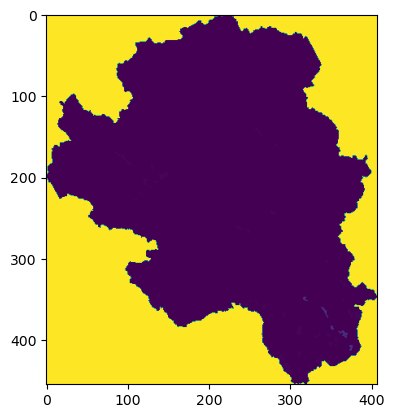

In [67]:
file1 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1.tif'
file2 = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J2.tif'
out_fp = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/Krycklan data/GIS/SOIL/krycklan_QD/krycklan_QD_J1_J2.tif'
fill_layer_na_with_layer(priority_layer=file1, secondary_layer=file2, out_fp=out_fp)

In [48]:
np.unique(data1)

array([  31.,   50.,   75.,   84.,   86.,   89.,   91.,  100.,  200.,
        888., 8809.,   nan])

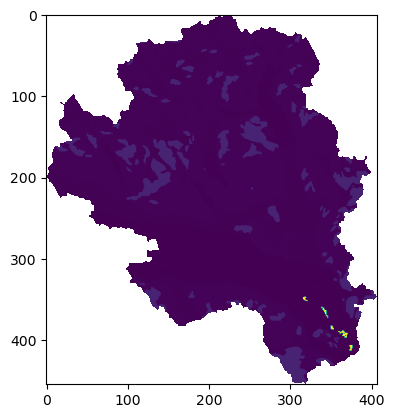

In [46]:
plt.imshow(data2)

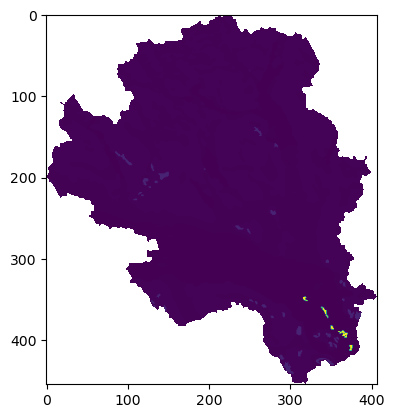

In [47]:
plt.imshow(data1)